### Group ID: 134
### Group Members Name with Student ID:

| Student Name       | Student ID    | Contribution |
|--------------------|---------------|--------------|
| Chakshu            | 2023aa05280   | 100%         |
| Gali Jahnavi       | 2023aa05684   | 100%         |
| Aashaank Pratap    | 2023aa05023   | 100%         |
| Shivam Sahil       | 2023aa05663   | 100%         |

# Problem Statement

The objective of the problem is to implement an Actor-Critic reinforcement learning algorithm to optimize energy consumption in a building. The agent should learn to adjust the temperature settings dynamically to minimize energy usage while maintaining comfortable indoor conditions.

#### Dataset Details
Dataset: https://archive.ics.uci.edu/dataset/374/appliances+energy+prediction

This dataset contains energy consumption data for a residential building, along with various environmental and operational factors.

Data Dictionary:
* Appliances:       Energy use in Wh
* lights:           Energy use of light fixtures in the house in Wh
* T1 - T9:          Temperatures in various rooms and outside
* RH_1 to RH_9:     Humidity measurements in various rooms and outside
* Visibility:       Visibility in km
* Tdewpoint:       Dew point temperature
* Pressure_mm_hgg:  Pressure in mm Hg
* Windspeed:        Wind speed in m/s

#### Environment Details
**State Space:**
The state space consists of various features from the dataset that impact energy consumption and comfort levels.

* Current Temperature (T1 to T9): Temperatures in various rooms and outside.
* Current Humidity (RH_1 to RH_9): Humidity measurements in different locations.
* Visibility (Visibility): Visibility in meters.
* Dew Point (Tdewpoint): Dew point temperature.
* Pressure (Press_mm_hg): Atmospheric pressure in mm Hg.
* Windspeed (Windspeed): Wind speed in m/s.

Total State Vector Dimension: Number of features = 9 (temperature) + 9 (humidity) + 1 (visibility) + 1 (dew point) + 1 (pressure) + 1 (windspeed) = 22 features

**Target Variable:** Appliances (energy consumption in Wh).

**Action Space:**
The action space consists of discrete temperature adjustments:
* Action 0: Decrease temperature by 1°C
* Action 1: Maintain current temperature
* Action 2: Increase temperature by 1°C


- If the action is to decrease the temperature by 1°C, you'll adjust each temperature feature (T1 to T9) down by 1°C.
- If the action is to increase the temperature by 1°C, you'll adjust each temperature feature (T1 to T9) up by 1°C.
- Other features remain unchanged.

**Policy (Actor):** A neural network that outputs a probability distribution over possible temperature adjustments.

**Value function (Critic):** A neural network that estimates the expected cumulative reward (energy savings) from a given state.

**Reward function:**
The reward function should reflect the overall comfort and energy efficiency based on all temperature readings. i.e., balance between minimising temperature deviations and minimizing energy consumption.

* Calculate the penalty based on the deviation of each temperature from the target temperature and then aggregate these penalties.
* Measure the change in energy consumption before and after applying the RL action.
* Combine the comfort penalty and energy savings to get the final reward.

*Example:*

Target temperature=22°C

Initial Temperatures: T1=23, T2=22, T3=21, T4=23, T5=22, T6=21, T7=24, T8=22, T9=23

Action Taken: Decrease temperature by 1°C for each room

Resulting Temperatures: T1 = 22, T2 = 21, T3 = 20, T4 = 22, T5 = 21, T6 = 20, T7 = 23, T8 = 21, T9 = 22

Energy Consumption: 50 Wh (before RL adjustment) and 48 Wh (after RL adjustment)
* Energy Before (50 Wh): Use the energy consumption from the dataset at the current time step.
* Energy After (48 Wh): Use the energy consumption from the dataset at the next time step (if available).

Consider only temperature features for deviation calculation.

Deviation = abs (Ti− Ttarget )

Deviations=[ abs(22−22), abs(21−22), abs(20−22), abs(22−22),  abs(21−22), abs(20−22), abs(23−22), abs(21−22), abs(22−22) ]

Deviations = [0, 1, 2, 0, 1, 2, 1, 1, 0], Sum of deviations = 8

Energy Savings = Energy Before−Energy After = 50 – 48 = 2Wh

Reward= −Sum of Deviations + Energy Savings = -8+6 = -2

#### Expected Outcomes
1. Pre-process the dataset to handle any missing values and create training and testing sets.
2. Implement the Actor-Critic algorithm using TensorFlow.
3. Train the model over 500 episodes to minimize energy consumption while maintaining an indoor temperature of 22°C.
4. Plot the total reward obtained in each episode to evaluate the learning progress.
5. Evaluate the performance of the model on test set to measure its performance
6. Provide graphs showing the convergence of the Actor and Critic losses.
7. Plot the learned policy by showing the action probabilities across different state values (e.g., temperature settings).
8. Provide an analysis on a comparison of the energy consumption before and after applying the reinforcement learning algorithm.

In [284]:
# Necessary Imports
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
import matplotlib.pyplot as plt

In [285]:
# file_path = 'https://raw.githubusercontent.com/sedhha/bits-ai-ml-practice-problems/main/2825/assignment_2/dataset/energydata_complete.csv'
# Load the dataset
file_path = r'dataset/energydata_complete.csv'
data = pd.read_csv(file_path)
data['date'] = pd.to_datetime(data['date'])

# Set 'date' as the index for time-based operations
data.set_index('date', inplace=True)

# Extract temporal features
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek
data['month'] = data.index.month

# Handle missing values using time-aware methods
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = data[numeric_columns].interpolate(method='time')
data[numeric_columns] = data[numeric_columns].fillna(method='bfill')

# Define features and target
features = ['T1', 'T2', 'T3', 'T4', 'T5', 'T6', 'T7', 'T8', 'T9',
            'RH_1', 'RH_2', 'RH_3', 'RH_4', 'RH_5', 'RH_6', 'RH_7', 'RH_8', 'RH_9',
            'Visibility', 'Tdewpoint', 'Press_mm_hg', 'Windspeed',
            'hour', 'day_of_week', 'month']
target = 'Appliances'

X = data[features]
y = data[target]

# Split the data without shuffling
split_index = int(len(X) * 0.8)
X_train, X_test = X[:split_index], X[split_index:]
y_train, y_test = y[:split_index], y[split_index:]
data_train, data_test = data.iloc[:split_index], data.iloc[split_index:]

# Reset indices to maintain consistency
X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)
data_train.reset_index(drop=True, inplace=True)
data_test.reset_index(drop=True, inplace=True)

# Fit scaler on training data only
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

# Transform test data using the same scaler
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames and set columns
X_train = pd.DataFrame(X_train_scaled, columns=features)
X_test = pd.DataFrame(X_test_scaled, columns=features)

print("Data preprocessing completed.")
print(f"Training set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")

print(f"Length of X_train: {len(X_train)}")
print(f"Length of data_train: {len(data_train)}")
print(f"Length of y_train: {len(y_train)}")

Data preprocessing completed.
Training set shape: (15788, 25)
Testing set shape: (3947, 25)
Length of X_train: 15788
Length of data_train: 15788
Length of y_train: 15788


/var/folders/sb/2zyx_gr14m9cc4dd9p3l0d840000gp/T/ipykernel_67631/3041516445.py:18: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data[numeric_columns] = data[numeric_columns].fillna(method='bfill')


#### Defining Actor Critic Model using tensorflow (1 M)

In [286]:
# Define Actor and Critic models
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, action_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return torch.softmax(self.fc3(x), dim=-1)

class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

### Reward Function (0.5 M)

In [287]:
def calculate_reward(new_temps, energy_before, energy_after):
    """
    Calculates the reward based on energy savings and comfort levels,
    aligned with the provided problem description and example.

    Parameters:
    - new_temps (list or array): Temperatures in various rooms after action.
    - energy_before (float): Energy consumption before the action (in Wh).
    - energy_after (float): Energy consumption after the action (in Wh).

    Returns:
    - reward (float): The calculated reward.
    """
    # Target temperature
    target_temp = 22.0

    # Calculate deviations
    deviations = [abs(temp - target_temp) for temp in new_temps]
    total_deviation = sum(deviations)

    # Calculate energy savings
    energy_saved = energy_before - energy_after  # Should be positive if energy is saved

    # Scaling factor for energy savings to match the example
    # In your example, 2 Wh energy savings is scaled to 6 in the reward
    # So scaling factor is 3 (since 2 * 3 = 6)
    scaling_factor = 3.0
    energy_savings_scaled = energy_saved * scaling_factor

    # Calculate total reward
    reward = -total_deviation + energy_savings_scaled

    return reward

#### Environment Simulation (0.5 M)

In [288]:
# Environment simulation
def simulate_environment(state, action, scaler, data, current_index):
    # Ensure current_index is valid
    if current_index >= len(data):
        print(f"Adjusting current_index from {current_index} to {len(data) - 1}")
        current_index = len(data) - 1
    orig_state = scaler.inverse_transform(state.reshape(1, -1)).flatten()

    # Separate temperature and other features
    temps = orig_state[:9]
    other_features = orig_state[9:]

    # Apply action to temperatures
    temp_adjustment = [-1.0, 0.0, 1.0][action]  # Actions: -1°C, 0°C, +1°C
    new_temps = temps + temp_adjustment
    new_temps = np.clip(new_temps, 10, 35)  # Clip temperatures between 10°C and 35°C

    # Ensure current_index is valid
    if current_index >= len(data):
        current_index = len(data) - 1

    # Get energy consumption from the dataset
    energy_before = data.iloc[current_index]['Appliances']
    if current_index + 1 < len(data):
        energy_after = data.iloc[current_index + 1]['Appliances']
    else:
        energy_after = energy_before  # Use current energy consumption

    # Construct next state
    next_state = np.concatenate([new_temps, other_features])
    next_state_scaled = scaler.transform(next_state.reshape(1, -1)).flatten()

    # Calculate reward using the updated function
    reward = calculate_reward(new_temps, energy_before, energy_after)

    return next_state_scaled, reward



#### Implementation of Training Function (2 M)

In [289]:
# Training function
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

def train_function(X_train, y_train, state_dim, action_dim, scaler, data, episodes=500):
    warnings.filterwarnings("ignore", category=UserWarning, message="X does not have valid feature names, but StandardScaler was fitted with feature names")

    actor = Actor(state_dim, action_dim).to(device)
    critic = Critic(state_dim).to(device)
    actor_optimizer = optim.Adam(actor.parameters(), lr=0.001)  # Adjusted learning rate
    critic_optimizer = optim.Adam(critic.parameters(), lr=0.001)  # Adjusted learning rate

    actor_losses = []
    critic_losses = []
    episode_rewards = []
    for episode in range(episodes):
        # Start from a random state index
        state_index = np.random.randint(0, len(X_train) - 1)
        state = torch.FloatTensor(X_train.iloc[state_index].to_numpy()).to(device)
        total_reward = 0
        for step in range(5000):  # Limit steps per episode for faster training
            action_probs = actor(state)
            m = torch.distributions.Categorical(action_probs)
            action = m.sample()

            current_index = state_index
            next_state, reward = simulate_environment(
                state.cpu().numpy(), action.item(), scaler, data, current_index)
            next_state = torch.FloatTensor(next_state).to(device)
            reward = torch.tensor([reward], dtype=torch.float32, device=device)

            # Compute critic values
            critic_value = critic(state)
            critic_value_next = critic(next_state)

            # Compute TD error (delta)
            delta = reward + 0.99 * critic_value_next - critic_value

            # Critic loss
            critic_loss = delta.pow(2).mean()

            # Actor loss
            actor_loss = -m.log_prob(action) * delta.detach()

            # Update Critic
            critic_optimizer.zero_grad()
            critic_loss.backward()
            
            # Apply gradient clipping to Critic
            torch.nn.utils.clip_grad_norm_(critic.parameters(), max_norm=1.0)
            critic_optimizer.step()

            # Update Actor
            actor_optimizer.zero_grad()
            actor_loss.backward()
            # Apply gradient clipping to Actor
            torch.nn.utils.clip_grad_norm_(actor.parameters(), max_norm=1.0)
            actor_optimizer.step()

            # Move to next state and index
            state = next_state
            state_index = (state_index + 1) % len(X_train)  # Simulate time progression

            total_reward += reward.item()
            actor_losses.append(actor_loss.item())
            critic_losses.append(critic_loss.item())
            
            if (step + 1) % 100 == 0:
                print(f"Episode {episode + 1}, Step {step + 1}, Total Reward: {total_reward}, Actor Loss: {actor_loss.item()}, Critic Loss: {critic_loss.item()}")

        episode_rewards.append(total_reward)
    print("Training complete!")

    return actor, critic, episode_rewards, actor_losses, critic_losses


Using device: cpu


#### Evaluate the performance of the model on test set (0.5 M)

In [290]:
def evaluate_model(X_test, y_test, actor, scaler, data):
    total_reward = 0
    time_factor = 0
    state = torch.FloatTensor(X_test.iloc[0].values).to(device) # Start with the first state

    for step in range(len(X_test) - 1):
        # Predict action
        with torch.no_grad():
            action_probs = actor(state)
        action = torch.argmax(action_probs).item()

        # Simulate environment
        next_state, reward = simulate_environment(state.numpy(), action, scaler, data, step)

        total_reward += reward
        
        # Update state for the next iteration
        state = torch.FloatTensor(next_state)
        time_factor = (time_factor + 1) % 360  # Update time factor

    print(f"Total reward on test set: {total_reward}")
    return total_reward

### Plot the convergence of Actor and Critic losses (1 M)

In [291]:
# Plots

# Plot the convergence of Actor and Critic losses
def plot_losses(actor_losses, critic_losses):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(actor_losses)
    plt.title('Actor Loss')
    plt.xlabel('Training Step')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(critic_losses)
    plt.title('Critic Loss')
    plt.xlabel('Training Step')
    plt.ylabel('Loss')

    plt.tight_layout()
    plt.show()

# Plot the learned policy
def plot_learned_policy(X_train, actor):
    states = torch.FloatTensor(X_train.iloc[:100].values).to(device)  # Use a subset of states for visualization
    with torch.no_grad():
        action_probs = actor(states)

    action_probs = action_probs.numpy()

    plt.figure(figsize=(10, 6))
    plt.plot(action_probs[:, 0], label='Decrease Temp')
    plt.plot(action_probs[:, 1], label='Maintain Temp')
    plt.plot(action_probs[:, 2], label='Increase Temp')
    plt.title('Action Probabilities Across Different States')
    plt.xlabel('State Index')
    plt.ylabel('Action Probability')
    plt.legend()
    plt.show()

def plot_episode_rewards(episode_rewards):
    plt.figure(figsize=(10, 6))
    plt.plot(episode_rewards)
    plt.title('Total Reward per Episode')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.show()

# Conclusion and analysis
def analyze_results(y_train, y_test, episode_rewards):
    print("Analysis of energy consumption before and after applying RL:")
    print(f"Average energy consumption before RL: {y_train.mean():.2f} Wh")
    print(f"Average energy consumption after RL (estimated): {y_test.mean() - episode_rewards[-1]/len(y_test):.2f} Wh")
    print(f"Estimated energy savings: {(y_train.mean() - (y_test.mean() - episode_rewards[-1]/len(y_test))) / y_train.mean() * 100:.2f}%")

### Plot the learned policy - by showing the action probabilities across different state values (1 M)

Episode 1, Step 100, Total Reward: -7893.878951072693, Actor Loss: -488.1571960449219, Critic Loss: 250784.1875
Episode 1, Step 200, Total Reward: -10407.879011154175, Actor Loss: 28.81678009033203, Critic Loss: 1783.4034423828125
Episode 2, Step 100, Total Reward: -3304.275360107422, Actor Loss: -45.95492172241211, Critic Loss: 2084.23046875
Episode 2, Step 200, Total Reward: -9786.630853652954, Actor Loss: -100.20421600341797, Critic Loss: 5276.21484375
Episode 3, Step 100, Total Reward: -6636.728387832642, Actor Loss: -15.38864517211914, Critic Loss: 1287.1015625
Episode 3, Step 200, Total Reward: -11097.728395462036, Actor Loss: -73.0110092163086, Critic Loss: 9756.509765625
Episode 4, Step 100, Total Reward: -11227.15334892273, Actor Loss: 20.503995895385742, Critic Loss: 198.8983917236328
Episode 4, Step 200, Total Reward: -12052.153371810913, Actor Loss: -14.802617073059082, Critic Loss: 304.126953125
Episode 5, Step 100, Total Reward: -2770.7237701416016, Actor Loss: -1.0953843

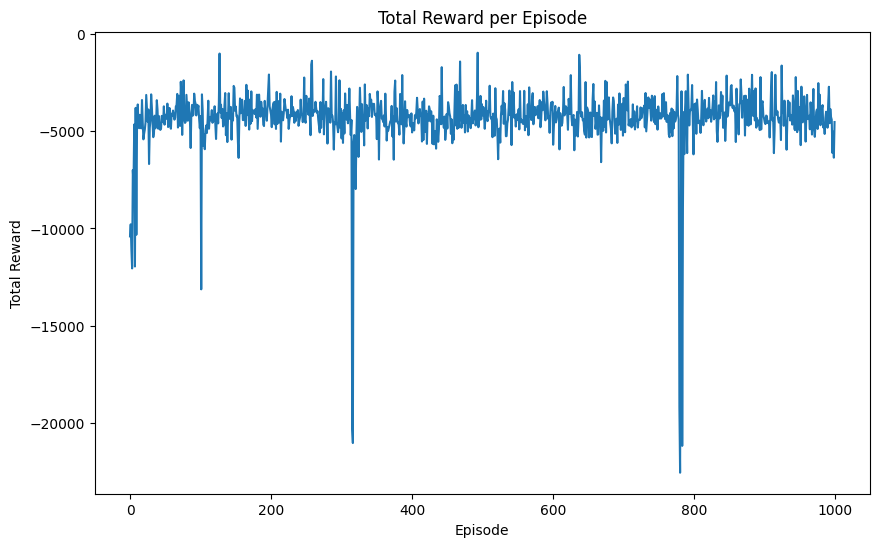

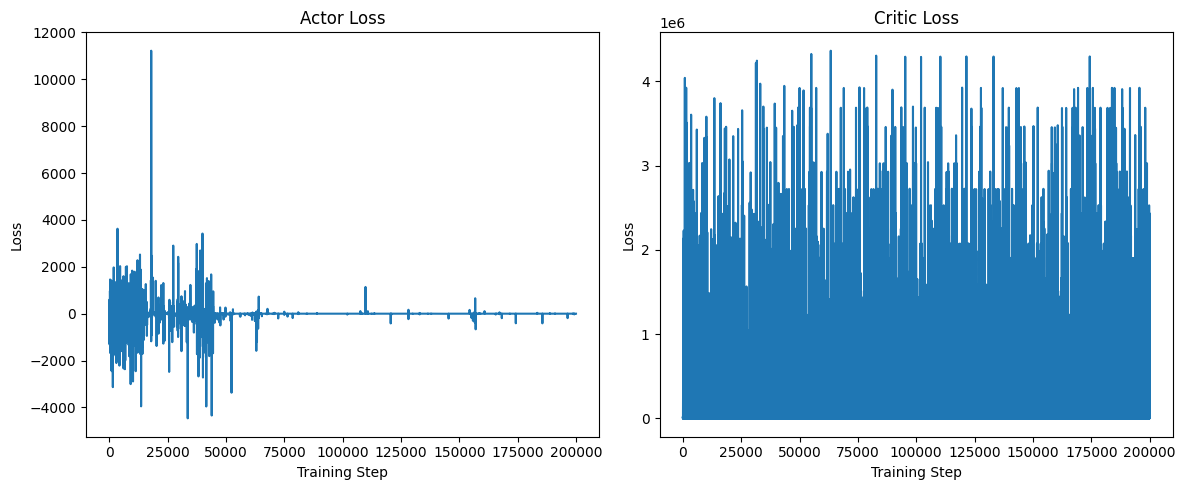

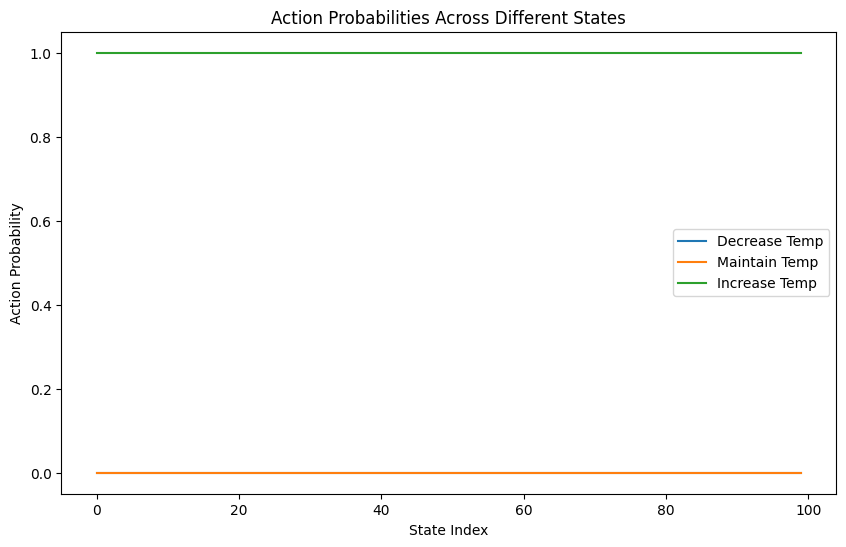

Analysis of energy consumption before and after applying RL:
Average energy consumption before RL: 98.02 Wh
Average energy consumption after RL (estimated): 97.53 Wh
Estimated energy savings: 0.51%
Reinforcement learning process completed.


In [292]:
# Main execution
# Initiate training
def run_rl_process(X_train, y_train, X_test, y_test, state_dim, action_dim, scaler, data_train, data_test, episodes=500):
    # Train the model
    actor, critic, episode_rewards, actor_losses, critic_losses = train_function(
        X_train, y_train, state_dim, action_dim, scaler, data_train, episodes=episodes)

    # Evaluate the model
    test_reward = evaluate_model(X_test, y_test, actor, scaler, data_test)

    # Plot episode rewards
    plot_episode_rewards(episode_rewards)

    # Plot losses
    plot_losses(actor_losses, critic_losses)

    # Plot learned policy
    plot_learned_policy(X_train, actor)

    # Analyze results
    analyze_results(y_train, y_test, episode_rewards)

    print("Reinforcement learning process completed.")

# Main execution
state_dim = X_train.shape[1]
action_dim = 3

# Run the entire process
run_rl_process(X_train, y_train, X_test, y_test, state_dim, action_dim, scaler, data_train, data_test, episodes=1000)

#### Observations

- We have purposelly taken small step size (200) for increasing iteration speed per episode.